## Importing

In [8]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error as mse

import os
from tqdm import tqdm


## Datasets Preparation (Training)

In [9]:
def datasets_preparation ():

     # Dataset and date    
     ds_name = ('/results2/SalishSea/nowcast-green.202111/' + i + '/SalishSea_1d_' + '20' + str(i[5:7]) + str(dict_month[i[2:5]])+str(i[0:2]) + '_' + '20' + str(i[5:7]) + str(dict_month[i[2:5]]) + str(i[0:2]) + '_grid_T.nc')

     ds_bio_name = ('/results2/SalishSea/nowcast-green.202111/' + i + '/SalishSea_1d_'  + '20' + str(i[5:7]) + str(dict_month[i[2:5]])+str(i[0:2]) + '_' + '20' + str(i[5:7]) + str(dict_month[i[2:5]]) + str(i[0:2]) + '_biol_T.nc')

     ds_prod_name = ('/results2/SalishSea/nowcast-green.202111/' + i + '/SalishSea_1d_'  + '20' + str(i[5:7]) + str(dict_month[i[2:5]])+str(i[0:2]) + '_' + '20' + str(i[5:7]) + str(dict_month[i[2:5]]) + str(i[0:2]) + '_prod_T.nc')

     ds = xr.open_dataset (ds_name)
     ds_bio = xr.open_dataset (ds_bio_name)
     ds_prod = xr.open_dataset(ds_prod_name)

     temp_i1 = (ds.votemper.where(mask==1)[0,0:15] * ds.e3t.where(mask==1)
               [0,0:15]).sum('deptht', skipna = True, min_count = 15) / mesh.gdepw_0[0,15]
     temp_i2 = (ds.votemper.where(mask==1)[0,15:27] * ds.e3t.where(mask==1)
               [0,15:27]).sum('deptht', skipna = True, min_count = 12) / (mesh.gdepw_0[0,27] - mesh.gdepw_0[0,14])
     saline_i1 = (ds.vosaline.where(mask==1)[0,0:15] * ds.e3t.where(mask==1)
                    [0,0:15]).sum('deptht', skipna = True, min_count = 15) / mesh.gdepw_0[0,15]
     saline_i2 = (ds.vosaline.where(mask==1)[0,15:27] * ds.e3t.where(mask==1)
                    [0,15:27]).sum('deptht', skipna = True, min_count = 12) / (mesh.gdepw_0[0,27] - mesh.gdepw_0[0,14])

     diat_i = (ds_prod.PPDIAT.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
               [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]
     flag_i = (ds_prod.PPPHY.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
               [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]

     return (temp_i1, temp_i2, saline_i1, saline_i2, diat_i, flag_i)


## Regressor

In [10]:
def regressor (inputs, targets, variable_name):
    
    inputs = inputs.transpose()
    
    # Regressor
    scale = preprocessing.StandardScaler()
    inputs2 = scale.fit_transform(inputs)
    X_train, X_test, y_train, y_test = train_test_split(inputs2, targets)

    extra_tree = ExtraTreeRegressor(criterion='poisson')
    regr = BaggingRegressor(extra_tree, n_estimators=10, max_features=4).fit(X_train, y_train)

    outputs_test = regr.predict(X_test)

    m = scatter_plot(y_test, outputs_test, variable_name + ' (Testing dataset)') 
    r = np.round(np.corrcoef(y_test, outputs_test)[0][1],3)
    rms = np.round(mse(y_test, outputs_test),4)
    

    return (r, rms, m, regr)

# Printing

In [11]:
def printing (targets, outputs, m):

    print ('The amount of data points is', outputs.size)
    print ('The slope of the best fitting line is ', np.round(m,3))
    print ('The correlation coefficient is:', np.round(np.corrcoef(targets, outputs)[0][1],3))
    print (' The mean square error is:', np.round(mse(targets,outputs),5))


## Scatter Plot

In [12]:
def scatter_plot(targets, outputs, variable_name):

    # compute slope m and intercept b
    m, b = np.polyfit(targets, outputs, deg=1)

    printing (targets, outputs, m)
    
    fig, ax = plt.subplots()

    plt.scatter(targets,outputs, alpha = 0.2, s = 10)
    plt.xlabel('targets')
    plt.ylabel('outputs')

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # plot fitted y = m*x + b
    plt.axline(xy1=(0, b), slope=m, color='r')

    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.plot(lims, lims,linestyle = '--',color = 'k')

    fig.suptitle(str(year) + ', ' + variable_name)

    plt.show()

    return (m)


## Plotting

In [13]:
def plotting (variable, name):

    plt.plot(years,variable, marker = '.', linestyle = '')
    plt.legend(['diatom','flagellate'])
    plt.xlabel('Years')
    plt.ylabel(name)
    plt.show()

## Main Body

  0%|          | 0/17 [00:00<?, ?it/s]

Gathering days for year 2007


100%|██████████| 75/75 [03:02<00:00,  2.44s/it]


Done gathering, building the prediction models


The amount of data points is 871482
The slope of the best fitting line is  0.907
The correlation coefficient is: 0.958
 The mean square error is: 0.0


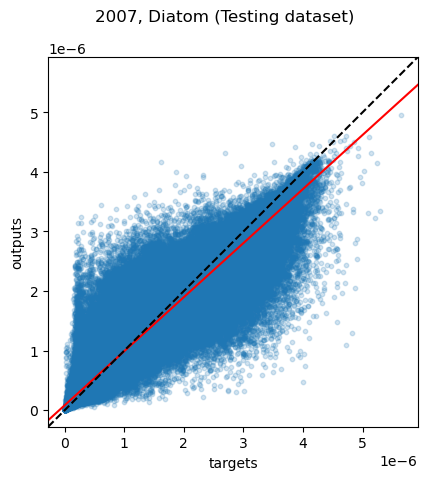

The amount of data points is 871482
The slope of the best fitting line is  0.839
The correlation coefficient is: 0.925
 The mean square error is: 0.0


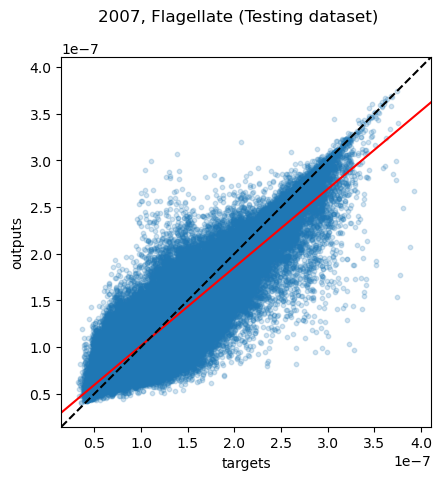

  6%|▌         | 1/17 [06:01<1:36:18, 361.13s/it]

Gathering days for year 2008


100%|██████████| 76/76 [03:11<00:00,  2.52s/it]


Done gathering, building the prediction models


The amount of data points is 883101
The slope of the best fitting line is  0.886
The correlation coefficient is: 0.947
 The mean square error is: 0.0


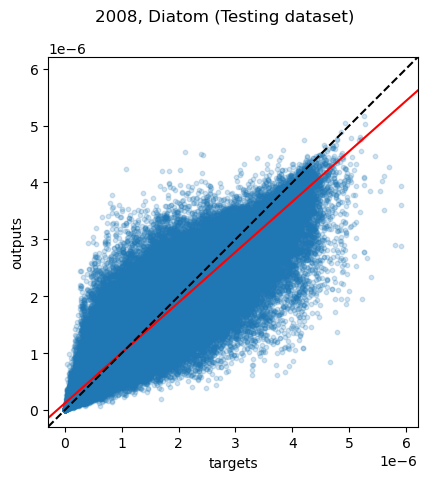

The amount of data points is 883101
The slope of the best fitting line is  0.829
The correlation coefficient is: 0.918
 The mean square error is: 0.0


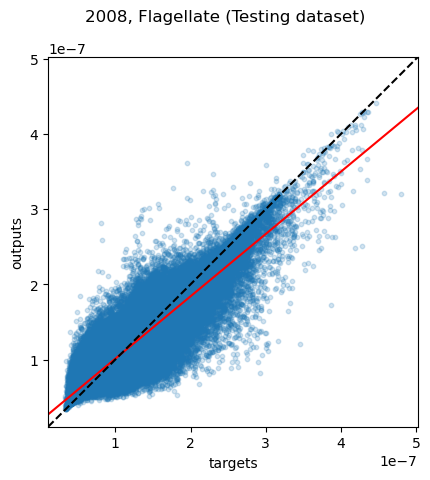

 12%|█▏        | 2/17 [12:13<1:31:56, 367.78s/it]

Gathering days for year 2009


100%|██████████| 75/75 [03:22<00:00,  2.69s/it]


Done gathering, building the prediction models


The amount of data points is 871482
The slope of the best fitting line is  0.908
The correlation coefficient is: 0.957
 The mean square error is: 0.0


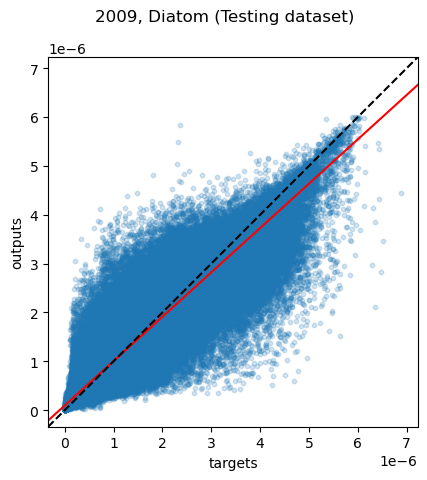

The amount of data points is 871482
The slope of the best fitting line is  0.81
The correlation coefficient is: 0.907
 The mean square error is: 0.0


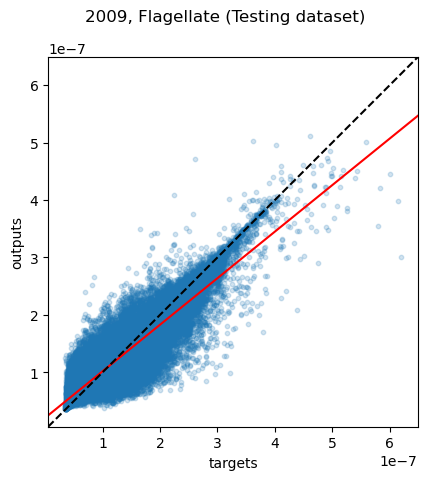

 18%|█▊        | 3/17 [18:27<1:26:27, 370.55s/it]

Gathering days for year 2010


100%|██████████| 75/75 [03:01<00:00,  2.42s/it]


Done gathering, building the prediction models


The amount of data points is 871482
The slope of the best fitting line is  0.888
The correlation coefficient is: 0.947
 The mean square error is: 0.0


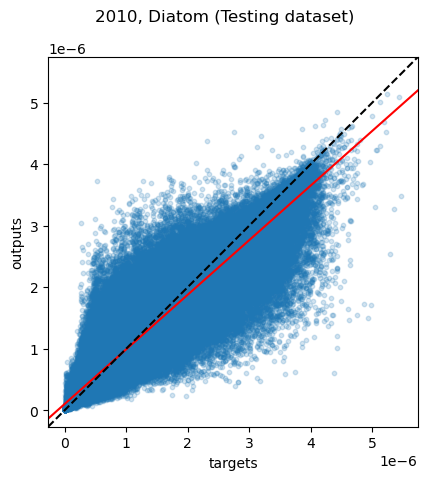

The amount of data points is 871482
The slope of the best fitting line is  0.799
The correlation coefficient is: 0.903
 The mean square error is: 0.0


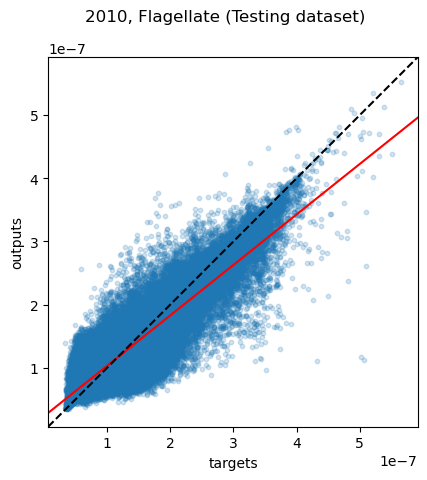

 24%|██▎       | 4/17 [24:26<1:19:19, 366.14s/it]

Gathering days for year 2011


100%|██████████| 75/75 [03:00<00:00,  2.40s/it]


Done gathering, building the prediction models


The amount of data points is 871482
The slope of the best fitting line is  0.9
The correlation coefficient is: 0.954
 The mean square error is: 0.0


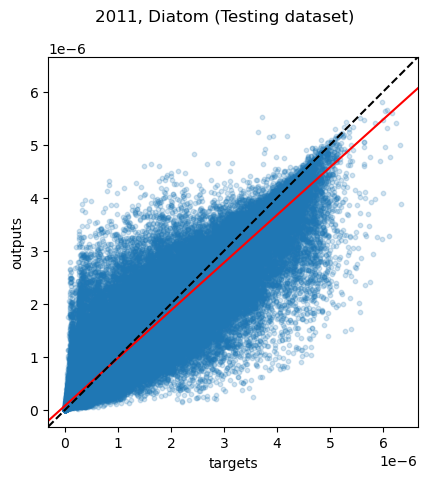

The amount of data points is 871482
The slope of the best fitting line is  0.821
The correlation coefficient is: 0.916
 The mean square error is: 0.0


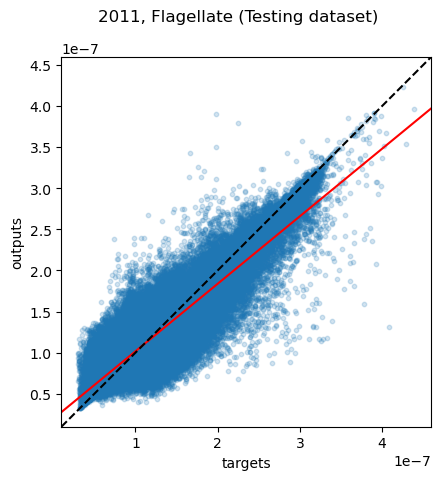

 29%|██▉       | 5/17 [30:21<1:12:24, 362.06s/it]

Gathering days for year 2012


100%|██████████| 76/76 [03:03<00:00,  2.41s/it]


Done gathering, building the prediction models


The amount of data points is 883101
The slope of the best fitting line is  0.897
The correlation coefficient is: 0.952
 The mean square error is: 0.0


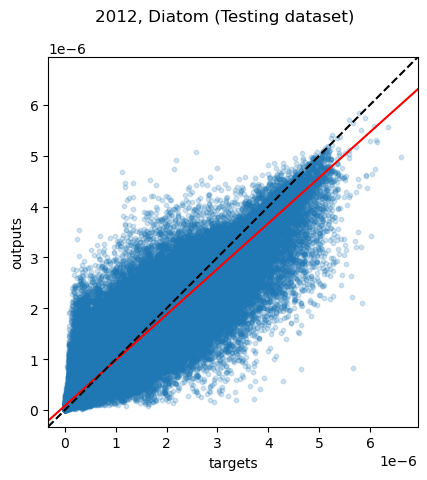

The amount of data points is 883101
The slope of the best fitting line is  0.805
The correlation coefficient is: 0.906
 The mean square error is: 0.0


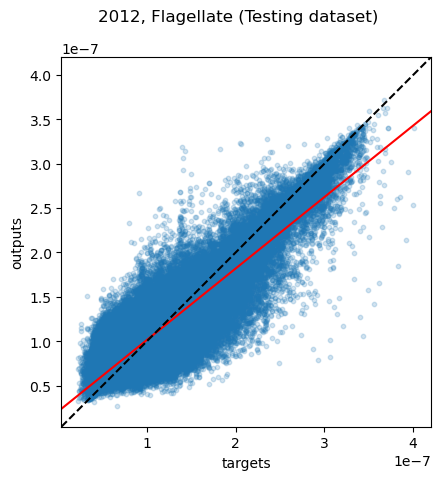

 35%|███▌      | 6/17 [36:17<1:05:59, 359.93s/it]

Gathering days for year 2013


100%|██████████| 75/75 [03:04<00:00,  2.45s/it]


Done gathering, building the prediction models


The amount of data points is 871482
The slope of the best fitting line is  0.865
The correlation coefficient is: 0.936
 The mean square error is: 0.0


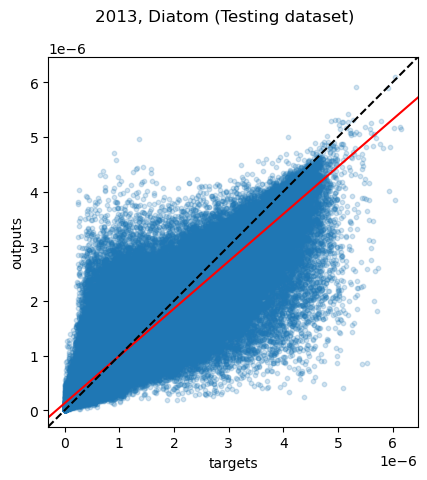

The amount of data points is 871482
The slope of the best fitting line is  0.805
The correlation coefficient is: 0.906
 The mean square error is: 0.0


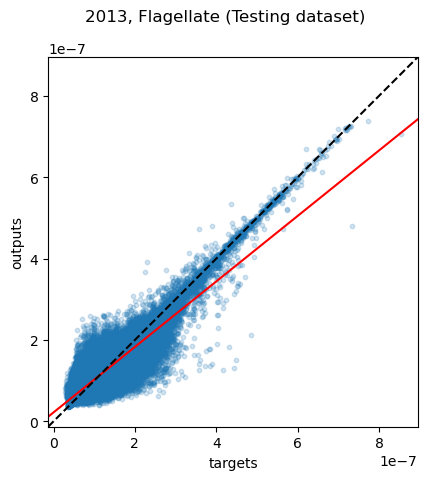

 41%|████      | 7/17 [42:12<59:42, 358.21s/it]  

Gathering days for year 2014


100%|██████████| 75/75 [03:04<00:00,  2.47s/it]


Done gathering, building the prediction models


The amount of data points is 871482
The slope of the best fitting line is  0.868
The correlation coefficient is: 0.938
 The mean square error is: 0.0


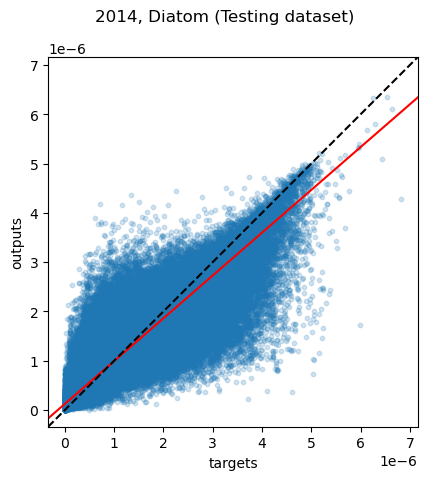

The amount of data points is 871482
The slope of the best fitting line is  0.839
The correlation coefficient is: 0.924
 The mean square error is: 0.0


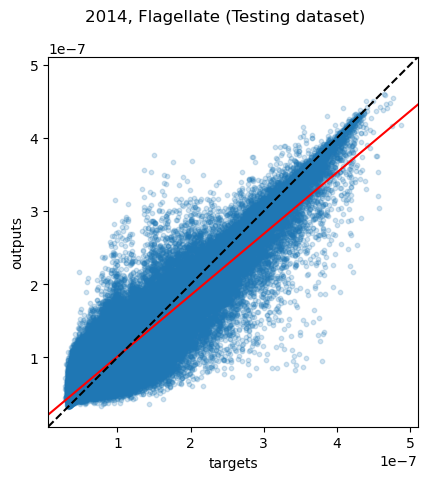

 47%|████▋     | 8/17 [48:07<53:35, 357.31s/it]

Gathering days for year 2015


100%|██████████| 75/75 [03:01<00:00,  2.42s/it]


Done gathering, building the prediction models


The amount of data points is 871482
The slope of the best fitting line is  0.821
The correlation coefficient is: 0.913
 The mean square error is: 0.0


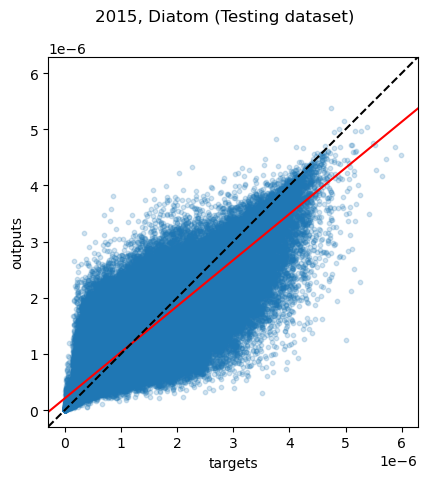

The amount of data points is 871482
The slope of the best fitting line is  0.839
The correlation coefficient is: 0.924
 The mean square error is: 0.0


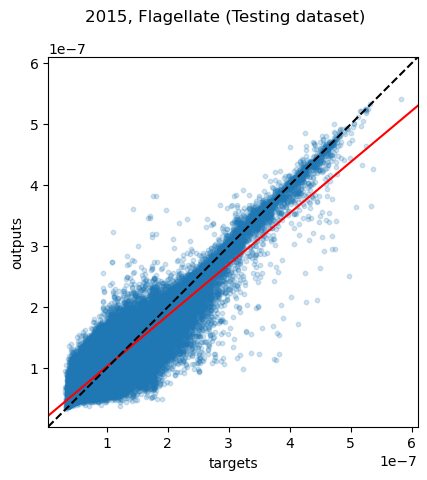

 53%|█████▎    | 9/17 [54:07<47:45, 358.20s/it]

Gathering days for year 2016


100%|██████████| 76/76 [03:09<00:00,  2.49s/it]


Done gathering, building the prediction models


The amount of data points is 883101
The slope of the best fitting line is  0.904
The correlation coefficient is: 0.956
 The mean square error is: 0.0


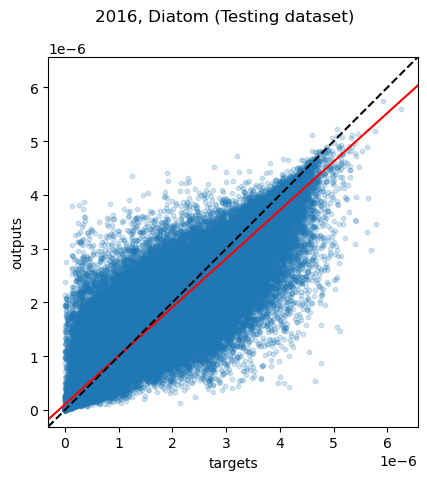

The amount of data points is 883101
The slope of the best fitting line is  0.825
The correlation coefficient is: 0.917
 The mean square error is: 0.0


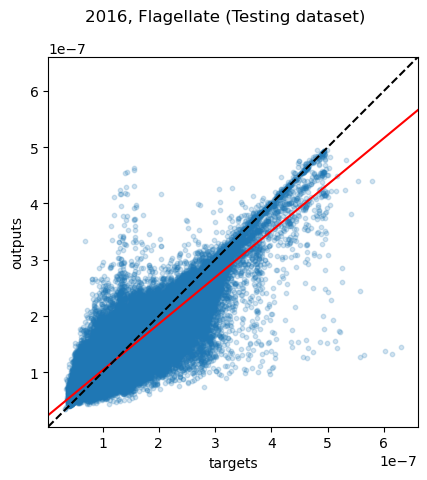

 59%|█████▉    | 10/17 [1:00:09<41:55, 359.37s/it]

Gathering days for year 2017


100%|██████████| 75/75 [03:01<00:00,  2.42s/it]


Done gathering, building the prediction models


The amount of data points is 871482
The slope of the best fitting line is  0.893
The correlation coefficient is: 0.951
 The mean square error is: 0.0


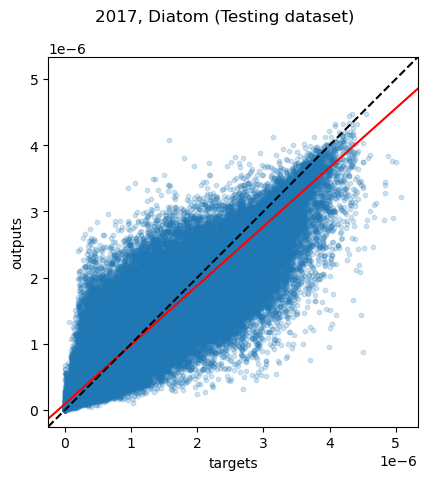

The amount of data points is 871482
The slope of the best fitting line is  0.81
The correlation coefficient is: 0.909
 The mean square error is: 0.0


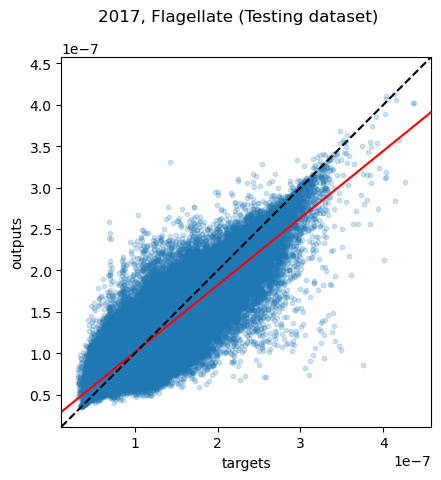

 65%|██████▍   | 11/17 [1:06:00<35:40, 356.72s/it]

Gathering days for year 2018


100%|██████████| 75/75 [03:02<00:00,  2.43s/it]


Done gathering, building the prediction models


The amount of data points is 871482
The slope of the best fitting line is  0.864
The correlation coefficient is: 0.936
 The mean square error is: 0.0


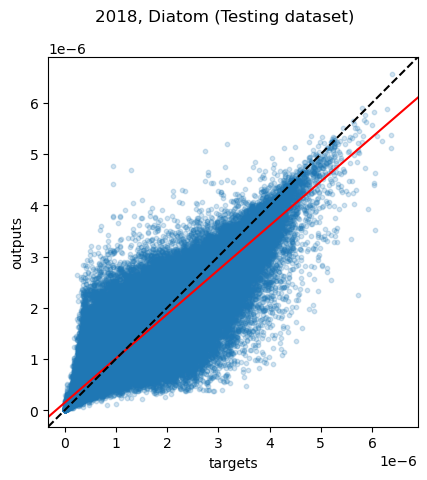

The amount of data points is 871482
The slope of the best fitting line is  0.872
The correlation coefficient is: 0.941
 The mean square error is: 0.0


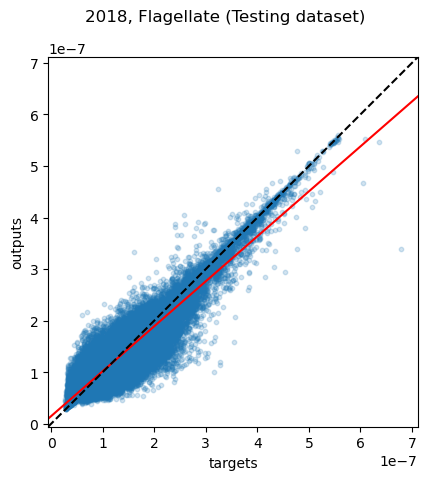

 71%|███████   | 12/17 [1:12:00<29:49, 357.81s/it]

Gathering days for year 2019


100%|██████████| 75/75 [03:00<00:00,  2.40s/it]


Done gathering, building the prediction models


The amount of data points is 871482
The slope of the best fitting line is  0.826
The correlation coefficient is: 0.914
 The mean square error is: 0.0


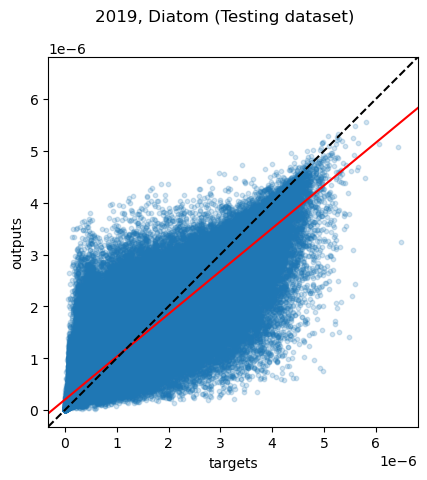

The amount of data points is 871482
The slope of the best fitting line is  0.783
The correlation coefficient is: 0.892
 The mean square error is: 0.0


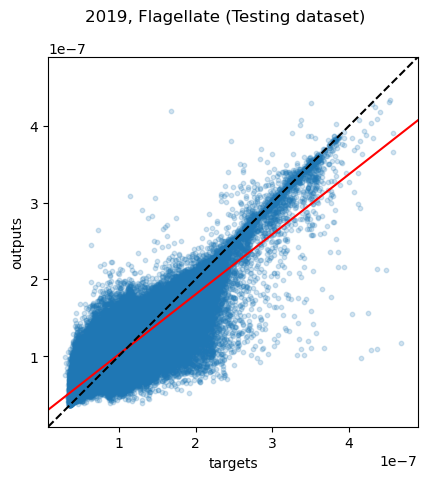

 76%|███████▋  | 13/17 [1:17:50<23:41, 355.48s/it]

Gathering days for year 2020


100%|██████████| 76/76 [02:59<00:00,  2.36s/it]


Done gathering, building the prediction models


The amount of data points is 883101
The slope of the best fitting line is  0.863
The correlation coefficient is: 0.935
 The mean square error is: 0.0


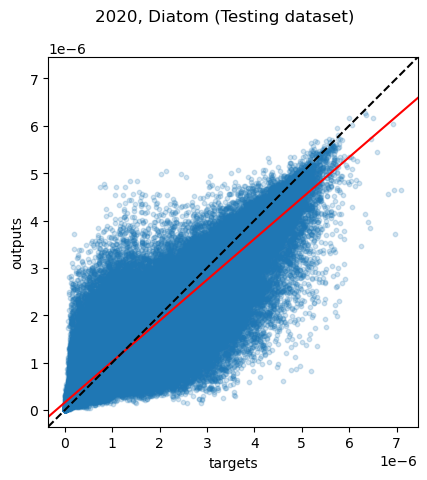

The amount of data points is 883101
The slope of the best fitting line is  0.809
The correlation coefficient is: 0.907
 The mean square error is: 0.0


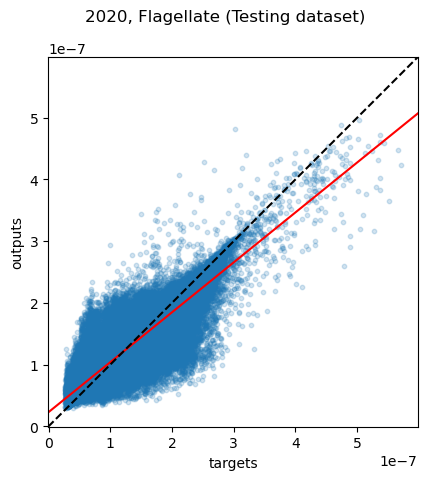

 82%|████████▏ | 14/17 [1:23:43<17:43, 354.56s/it]

Gathering days for year 2021


100%|██████████| 75/75 [03:00<00:00,  2.41s/it]


Done gathering, building the prediction models


The amount of data points is 871482
The slope of the best fitting line is  0.899
The correlation coefficient is: 0.953
 The mean square error is: 0.0


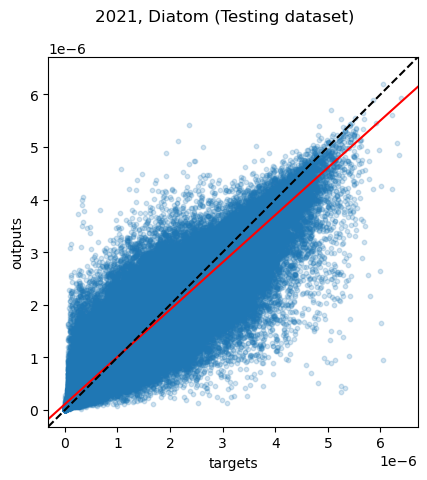

The amount of data points is 871482
The slope of the best fitting line is  0.783
The correlation coefficient is: 0.895
 The mean square error is: 0.0


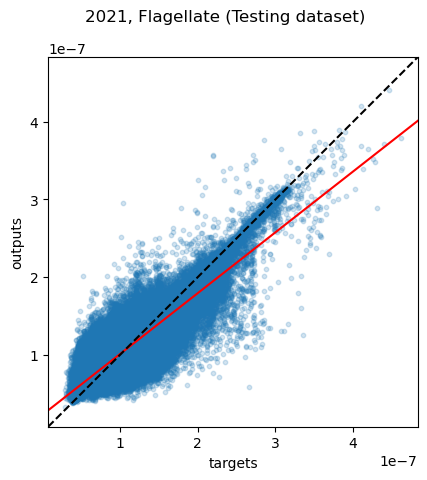

 88%|████████▊ | 15/17 [1:29:38<11:49, 354.72s/it]

Gathering days for year 2022


100%|██████████| 75/75 [03:02<00:00,  2.43s/it]


Done gathering, building the prediction models


The amount of data points is 871482
The slope of the best fitting line is  0.887
The correlation coefficient is: 0.947
 The mean square error is: 0.0


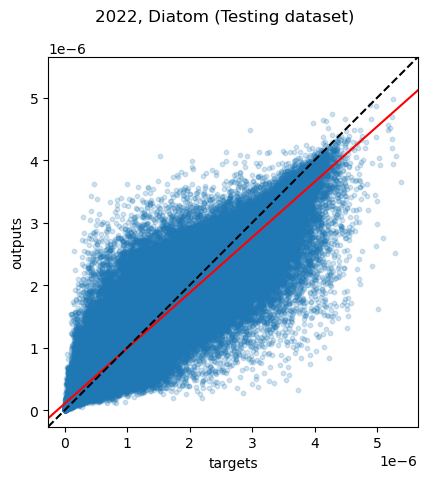

The amount of data points is 871482
The slope of the best fitting line is  0.745
The correlation coefficient is: 0.877
 The mean square error is: 0.0


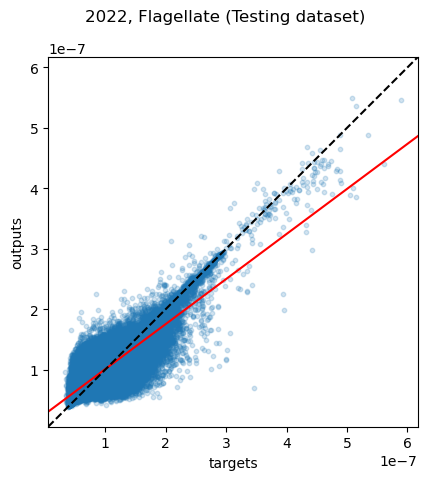

 94%|█████████▍| 16/17 [1:35:35<05:55, 355.60s/it]

Gathering days for year 2023


100%|██████████| 75/75 [03:13<00:00,  2.58s/it]


Done gathering, building the prediction models


The amount of data points is 871482
The slope of the best fitting line is  0.873
The correlation coefficient is: 0.939
 The mean square error is: 0.0


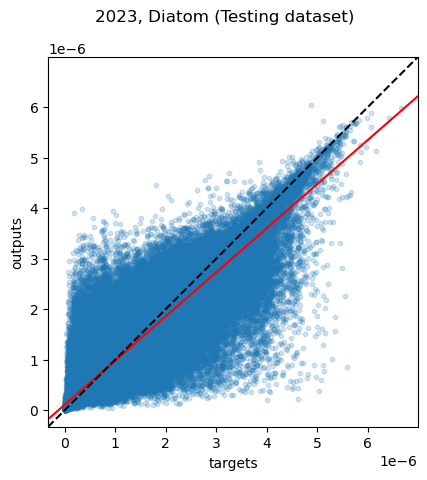

The amount of data points is 871482
The slope of the best fitting line is  0.795
The correlation coefficient is: 0.9
 The mean square error is: 0.0


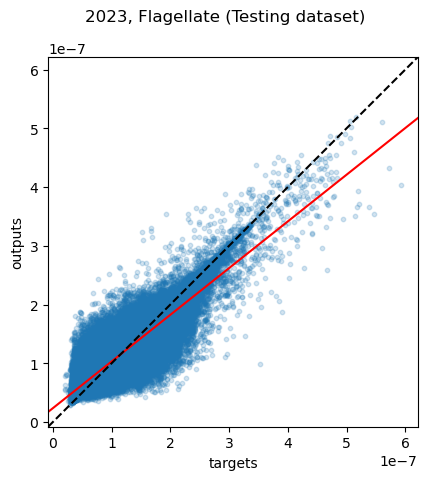

100%|██████████| 17/17 [1:41:40<00:00, 358.84s/it]


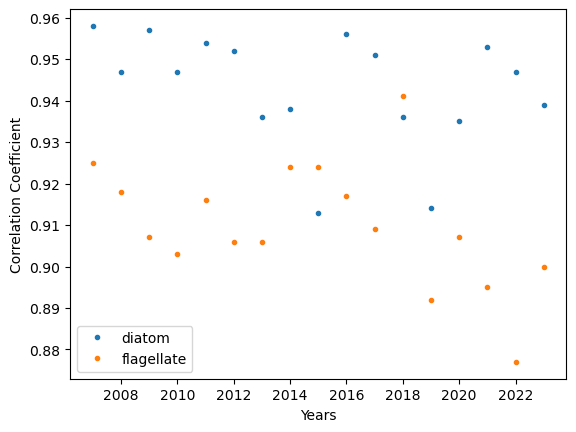

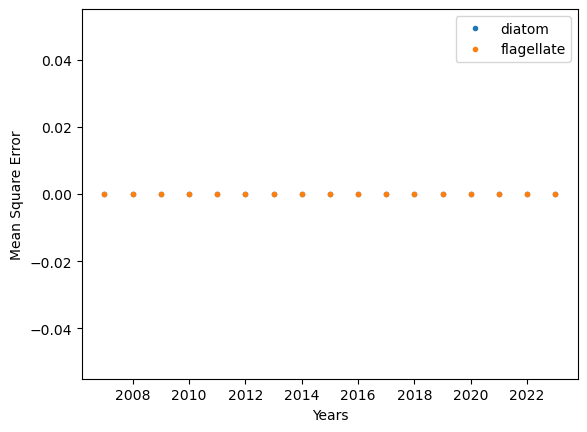

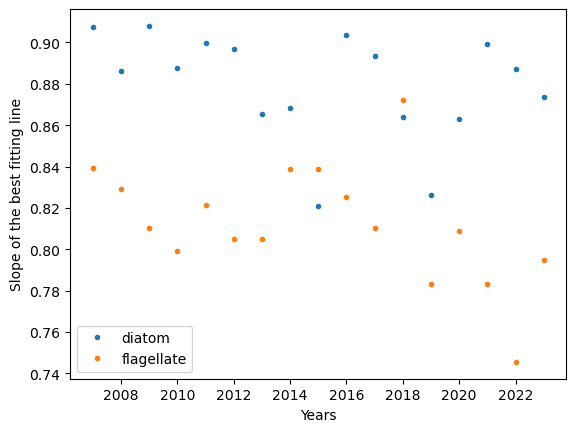

In [14]:
dict_month = {'jan': '01',
         'feb': '02',
         'mar': '03',
         'apr': '04',
         'may': '05',
         'jun': '06',
         'jul': '07',
         'aug': '08',
         'sep': '09',
         'oct': '10',
         'nov': '11',
         'dec': '12'}

path = os.listdir('/results2/SalishSea/nowcast-green.202111/')

years = range (2007,2024)

# Open the mesh mask
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
mask = mesh.tmask.to_numpy()

r_all = [],[]
rms_all = [],[]
slope_all = [],[]

for year in tqdm(range (2007,2024)):

    year_str = str(year)[2:4]

    folders = [x for x in path if ((x[2:5]=='mar' or x[2:5]=='apr' or (x[2:5]=='feb' and x[0:2] > '14')) and (x[5:7]==year_str))]
    indx_dates=(np.argsort(pd.to_datetime(folders, format="%d%b%y")))
    folders = [folders[i] for i in indx_dates]

    drivers_all = np.array([[],[],[],[]])
    diat_all = np.array([])
    flag_all = np.array([])

    print ('Gathering days for year ' + str(year))

    for i in tqdm(folders):

        temp_i1, temp_i2, saline_i1, saline_i2, diat_i, flag_i = datasets_preparation()

        drivers = np.stack([np.ravel(temp_i1), np.ravel(temp_i2), np.ravel(saline_i1), np.ravel(saline_i2)])
        indx = np.where(~np.isnan(drivers).any(axis=0))
        drivers = drivers[:,indx[0]]
        drivers_all = np.concatenate((drivers_all,drivers),axis=1)

        diat = np.ravel(diat_i)
        diat = diat[indx[0]]
        diat_all = np.concatenate((diat_all,diat))

        flag = np.ravel(flag_i)
        flag = flag[indx[0]]
        flag_all = np.concatenate((flag_all,flag))

    print ('Done gathering, building the prediction models')
    print ('\n')

    r, rms, m, regr = regressor(drivers_all, diat_all, 'Diatom')
    r_all[0].append(r)
    rms_all[0].append(rms)
    slope_all[0].append(m)

    r, rms, m, regr = regressor(drivers_all, flag_all, 'Flagellate')
    r_all[1].append(r)
    rms_all[1].append(rms)
    slope_all[1].append(m)

plotting(np.transpose(r_all), 'Correlation Coefficient')
plotting(np.transpose(rms_all), 'Mean Square Error')
plotting (np.transpose(slope_all), 'Slope of the best fitting line')
